In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from utils_torch import plot_mnist
from models.Mnist_torch import Mnist_torch


In [2]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, 
                        transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=1000, shuffle=False)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, inputs):
        return self.model(inputs)

In [5]:
model = Net()
model = Mnist_torch(model)

In [6]:
model.load_weights('mnist.pth')

In [7]:
model.get_layer_outputs

{'': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4250>,
 'model': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4550>,
 'model.0': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4280>,
 'model.1': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d42b0>,
 'model.2': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d41c0>,
 'model.3': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d45e0>,
 'model.4': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4cd0>,
 'model.5': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4d60>,
 'model.6': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4e20>,
 'model.7': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4f40>,
 'model.8': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4ee0>,
 'model.9': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d45b0>,
 'model.10': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4d00>,
 'model.11': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4130>,
 'model.12': <torch.utils.hooks.RemovableHandle at 0x7faf6b1d4070>}

In [8]:
dataset = torch.tensor([])
dataset_labels = torch.tensor([])
for num, (data, data_set) in enumerate(test_loader):
    if num == 0:
        dataset = torch.tensor(data)
        dataset_labels = torch.tensor(data_set)
    else:
        dataset = torch.cat((dataset, data), 0)
        dataset_labels = torch.cat((dataset_labels, data_set), 0)

/tmp/ipykernel_31177/1528009909.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data)
/tmp/ipykernel_31177/1528009909.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_labels = torch.tensor(data_set)


In [9]:
print(dataset.shape)
print(dataset_labels.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [10]:
dataset_labels

tensor([7, 2, 1,  ..., 4, 5, 6])

In [11]:
for name, module in model.model.named_modules():
    print(name)


model
model.0
model.1
model.2
model.3
model.4
model.5
model.6
model.7
model.8
model.9
model.10
model.11
model.12


In [12]:
all_layer_names = [layer[0] for layer in model.model.named_modules()]
layer_name = "model.2"
layer_id = all_layer_names.index(layer_name)
print(layer_id)

4


In [13]:
import ctypes
lib_file = "index/build/lib.linux-x86_64-3.8/deepeverst_index.cpython-38-x86_64-linux-gnu.so"
index_lib = ctypes.CDLL(lib_file)

In [14]:
import math
from utils_torch import *

n_images = len(dataset)
n_partitions= 64
batch_size = 64
ratio = 0.05
bits_per_image = math.ceil(math.log(n_partitions, 2))
print(n_images)
print(type(dataset))

10000
<class 'torch.Tensor'>


In [15]:
print(dataset.shape)
layer_result = get_layer_result_by_layer_id(model, dataset, layer_id, batch_size=None)

torch.Size([10000, 1, 28, 28])


In [16]:
# print(layer_result)
print(layer_result.shape)

torch.Size([10000, 10, 12, 12])


In [17]:
layer_result = layer_result.detach().numpy()
from DeepEverest_torch import *
rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx, par_low_bound, par_upp_bound = construct_index(
        index_lib=index_lib,
        n_images=n_images,
        ratio=ratio,
        n_partitions=n_partitions,
        bits_per_image=bits_per_image,
        layer_result=layer_result)

In [18]:
label_predicted = torch.argmax(model.predict(dataset), axis=1)
print(label_predicted)

tensor([7, 2, 1,  ..., 4, 5, 6])


In [19]:
label_test = dataset_labels
print(label_test)

tensor([7, 2, 1,  ..., 4, 5, 6])


In [20]:
misclassified_mask = label_predicted[:1000] != label_test[:1000]
np.where(misclassified_mask)

(array([ 33,  62,  73, 124, 209, 233, 241, 247, 259, 290, 318, 320, 321,
        445, 448, 449, 479, 495, 511, 530, 543, 551, 571, 582, 591, 659,
        684, 689, 691, 717, 720, 740, 810, 839, 894, 898, 900, 924, 926,
        938, 947, 950, 956, 965]),)

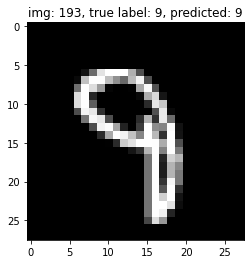

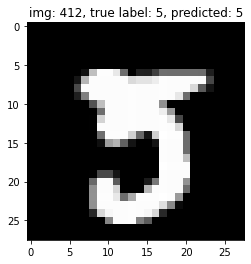

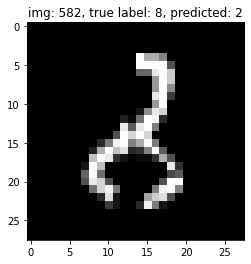

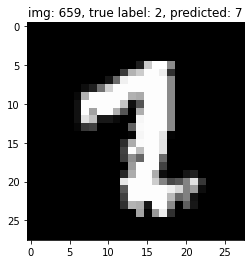

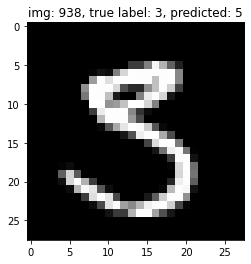

In [21]:
image_ids = [193, 412, 582, 659, 938]
for image_id in image_ids:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1)
    plot_mnist(dataset, label_test, image_id, prediction)

In [22]:
import heapq
def get_topk_activations_given_images(model, dataset, image_ids, layer_name, k):
    res = []
    image_samples = []
    for image_sample_id in image_ids:
        image_samples.append(dataset[image_sample_id])
    image_samples = torch.stack(image_samples)
    layer_result_image_samples = model.get_layer_result_by_layer_name(image_samples, layer_name)
    for idx, image_sample_id in enumerate(image_ids):
        heap = list()
        for neuron_idx, activation in np.ndenumerate(layer_result_image_samples[idx]):
            if len(heap) < k:
                heapq.heappush(heap, (activation, neuron_idx))
            elif (activation, neuron_idx) > heap[0]:
                heapq.heapreplace(heap, (activation, neuron_idx))
        res.append(sorted(heap, reverse=True))
    return res

Set the target input of interest and the number of top activations you want to inspect.  
For example, image 659 is a misclassified example in the dataset.  
Get the top-k activations for this input in this layer and their corresponding neuron IDs.

In [23]:
image_ids = [659]
k_global = 20
topk_activations = get_topk_activations_given_images(model, dataset, image_ids, layer_name, k_global)[0]
topk_activations_neurons = [x[1] for x in topk_activations]
topk_activations

[(15.056664, (4, 4, 6)),
 (14.274166, (4, 5, 6)),
 (13.664486, (4, 6, 6)),
 (13.554054, (4, 3, 6)),
 (13.502932, (4, 8, 6)),
 (13.477571, (4, 9, 6)),
 (13.340709, (1, 11, 6)),
 (13.27995, (4, 4, 7)),
 (13.197538, (1, 5, 3)),
 (13.188957, (4, 3, 7)),
 (13.090613, (1, 10, 6)),
 (12.774042, (1, 5, 4)),
 (12.733601, (4, 2, 6)),
 (12.522223, (4, 7, 6)),
 (12.089676, (4, 5, 7)),
 (11.97962, (1, 11, 7)),
 (11.603155, (4, 8, 5)),
 (11.496715, (4, 2, 7)),
 (11.474282, (0, 3, 7)),
 (11.457584, (1, 4, 4))]

Verify the activations are correct

In [24]:
res = []
image_samples = []
for image_sample_id in image_ids:
    image_samples.append(dataset[image_sample_id])
image_samples = torch.stack(image_samples)
layer_result_image_samples = model.get_layer_result_by_layer_name(image_samples, layer_name)
brute_force = []
for i in range(layer_result_image_samples.shape[1]):
    for j in range(layer_result_image_samples.shape[2]):
        for k in range(layer_result_image_samples.shape[3]):
            brute_force.append((layer_result_image_samples[0, i, j, k], (i, j, k)))
sorted_array = sorted(brute_force, key=lambda k:k[0], reverse=True)
print(sorted_array[:20])

[(tensor(15.0567), (4, 4, 6)), (tensor(14.2742), (4, 5, 6)), (tensor(13.6645), (4, 6, 6)), (tensor(13.5541), (4, 3, 6)), (tensor(13.5029), (4, 8, 6)), (tensor(13.4776), (4, 9, 6)), (tensor(13.3407), (1, 11, 6)), (tensor(13.2800), (4, 4, 7)), (tensor(13.1975), (1, 5, 3)), (tensor(13.1890), (4, 3, 7)), (tensor(13.0906), (1, 10, 6)), (tensor(12.7740), (1, 5, 4)), (tensor(12.7336), (4, 2, 6)), (tensor(12.5222), (4, 7, 6)), (tensor(12.0897), (4, 5, 7)), (tensor(11.9796), (1, 11, 7)), (tensor(11.6032), (4, 8, 5)), (tensor(11.4967), (4, 2, 7)), (tensor(11.4743), (0, 3, 7)), (tensor(11.4576), (1, 4, 4))]


Construct the group of neurons that you are interested in, e.g., the top-3 maximally activated neurons.

In [24]:
from NeuronGroup import *
image_sample_id = 659
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=topk_activations_neurons[:3])

In [25]:
topk_activations_neurons[:3]

[(4, 4, 6), (4, 5, 6), (4, 6, 6)]

In [26]:
dataset.shape

torch.Size([10000, 1, 28, 28])

Query for the k-nearest neighbors in the dataset using the activations of this group of neurons  
based on the proximity in the latent space defined by this group of neurons.  
answer_query_with_guarantee() runs the Neural Threshold Algorithm.

In [27]:
top_k, exit_msg, is_in_partition_0, n_images_rerun = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
top_k, exit_msg

image 659, size of neuron group 3
threshold: 0.10146905481815338, max in answer: 1.40303635597229, images run: 67
threshold: 0.20118562877178192, max in answer: 1.1438370943069458, images run: 132
threshold: 0.2788737714290619, max in answer: 0.9198803901672363, images run: 196
threshold: 0.42958271503448486, max in answer: 0.7807649374008179, images run: 260
threshold: 0.5854843854904175, max in answer: 0.7519282102584839, images run: 325
threshold: 0.7778107523918152, max in answer: 0.7440550923347473, images run: 389
======================= NTA exited =======================


([(-0.7440551, 2915),
  (-0.7409354, 6074),
  (-0.6970588, 8109),
  (-0.6478751, 7822),
  (-0.6055464, 3611),
  (-0.58405477, 6118),
  (-0.5718313, 4011),
  (-0.53731173, 8100),
  (-0.52412087, 4097),
  (-0.5215469, 4861),
  (-0.46935377, 6988),
  (-0.44762346, 6096),
  (-0.4275496, 8048),
  (-0.4268946, 7783),
  (-0.42228025, 1909),
  (-0.41333342, 3229),
  (-0.3712188, 1480),
  (-0.23766346, 8679),
  (-0.113409005, 8112),
  (0.0, 659)],
 'termination: images run: 389')

verify the result is correct

In [28]:
layer_result = get_layer_result_by_layer_id(model, dataset, layer_id, batch_size=None)
print(layer_result.shape)
print(topk_activations_neurons[:3])
search_target = np.array([layer_result[659][(4, 4, 6)].numpy(), layer_result[659][(4, 5, 6)].numpy(), layer_result[659][(4, 6, 6)].numpy()])
print(search_target)
result_array = []
for i in range(len(dataset)):
    number = np.array([layer_result[i][(4, 4, 6)].numpy(), layer_result[i][(4, 5, 6)].numpy(), layer_result[i][(4, 6, 6)].numpy()])
    distance = np.sqrt(np.sum((search_target - number) * (search_target - number)))
    result_array.append((distance, i))
result_array = sorted(result_array, key=lambda k: k[0], reverse=True)
print(result_array[-20:])

torch.Size([10000, 10, 12, 12])
[(4, 4, 6), (4, 5, 6), (4, 6, 6)]
[15.056664 14.274166 13.664486]
[(0.7440551, 2915), (0.7409354, 6074), (0.6970588, 8109), (0.6478751, 7822), (0.6055464, 3611), (0.58405477, 6118), (0.5718313, 4011), (0.53731173, 8100), (0.52412087, 4097), (0.5215469, 4861), (0.46935377, 6988), (0.44762346, 6096), (0.4275496, 8048), (0.4268946, 7783), (0.42228025, 1909), (0.41333342, 3229), (0.3712188, 1480), (0.23766346, 8679), (0.113409005, 8112), (0.0, 659)]


Visualize the top-k results.

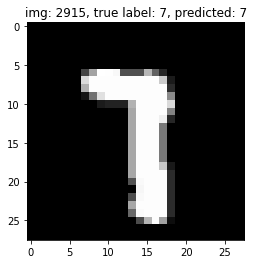

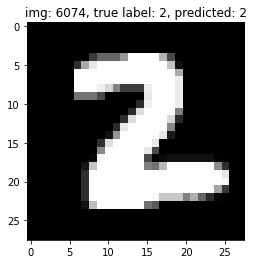

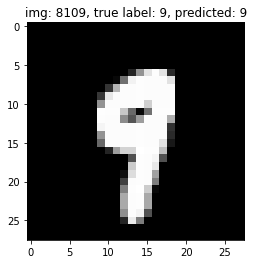

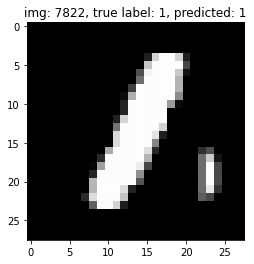

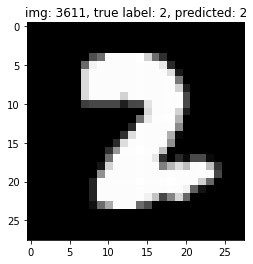

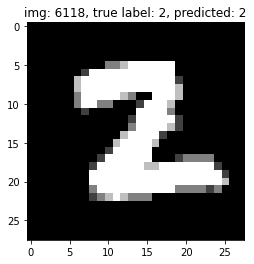

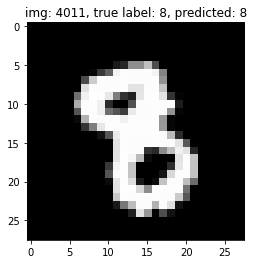

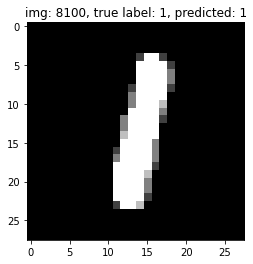

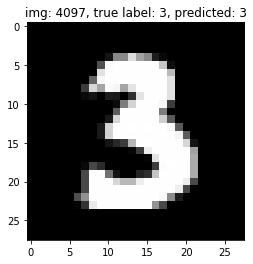

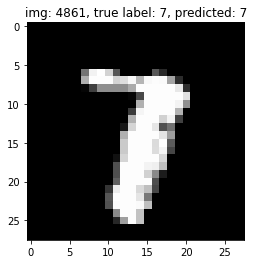

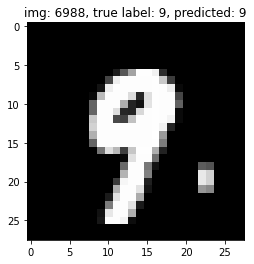

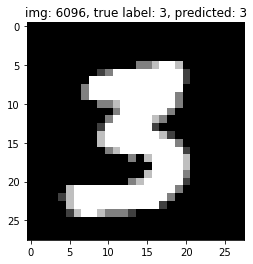

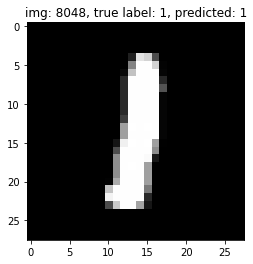

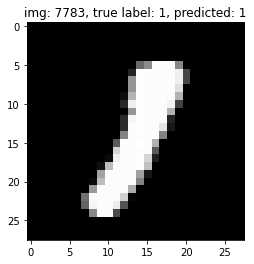

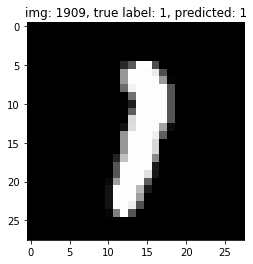

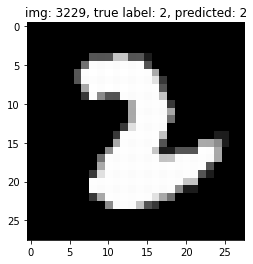

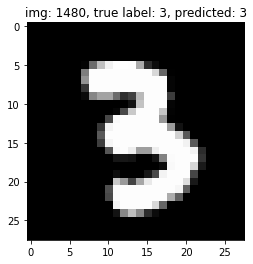

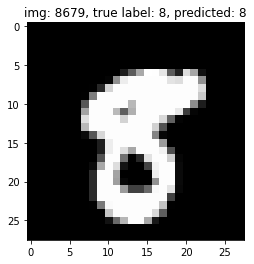

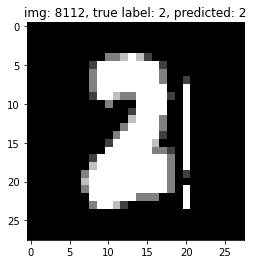

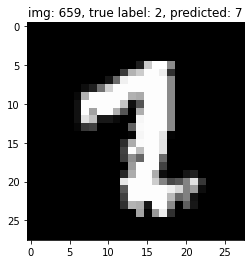

In [29]:
for neg_dist, image_id in top_k:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

In [30]:
def predict_2_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 2

def predict_7_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 7

def predict_2_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 2

def predict_7_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 7

In [31]:
seven_as_two = -1
two_as_seven = -1
two_as_two = -1
seven_as_seven = -1
for image_id in range(dataset.shape[0]):
    if seven_as_two < 0 and predict_7_as_2(image_id):
        seven_as_two = image_id
    if two_as_seven < 0 and predict_2_as_7(image_id):
        two_as_seven = image_id
    if two_as_two < 0 and predict_2_as_2(image_id):
        two_as_two = image_id
    if seven_as_seven < 0 and predict_7_as_7(image_id):
        seven_as_seven = image_id
    if seven_as_two > 0 and two_as_seven > 0 and two_as_two > 0 and seven_as_seven > 0:
        break

print(two_as_two, seven_as_seven, two_as_seven, seven_as_two)

1 0 321 810


In [32]:
image_ids = [two_as_two, seven_as_seven, two_as_seven, seven_as_two]

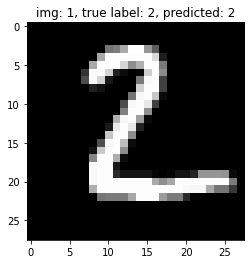

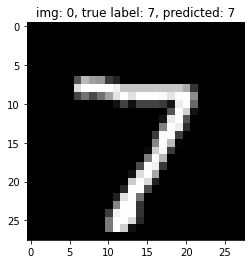

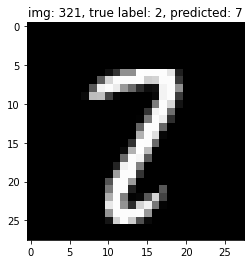

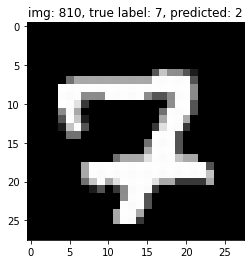

In [33]:
for image_id in image_ids:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

In [34]:
k_global = 20
topk_activations = get_topk_activations_given_images(model, dataset, image_ids, layer_name, k_global)
topk_activations

[[(15.404506, (1, 10, 6)),
  (14.740844, (1, 10, 9)),
  (14.725686, (1, 10, 5)),
  (14.658377, (1, 10, 4)),
  (14.074226, (1, 10, 7)),
  (14.018891, (1, 10, 10)),
  (13.745972, (1, 10, 3)),
  (13.607746, (1, 2, 5)),
  (13.291188, (1, 10, 8)),
  (12.143644, (1, 2, 4)),
  (11.776539, (4, 2, 6)),
  (11.771938, (4, 6, 4)),
  (11.722886, (4, 8, 3)),
  (11.716561, (1, 1, 5)),
  (11.585614, (4, 3, 6)),
  (11.531162, (4, 7, 3)),
  (11.222839, (4, 5, 4)),
  (11.1286335, (4, 4, 5)),
  (11.101066, (1, 10, 11)),
  (11.002071, (4, 5, 5))],
 [(14.003622, (1, 4, 4)),
  (13.753479, (1, 4, 5)),
  (13.233683, (1, 4, 3)),
  (13.210785, (1, 4, 6)),
  (12.756104, (1, 4, 7)),
  (10.772835, (4, 11, 4)),
  (10.763884, (4, 10, 5)),
  (10.652996, (4, 4, 8)),
  (10.51455, (1, 3, 3)),
  (10.362712, (1, 4, 2)),
  (10.331228, (1, 3, 2)),
  (9.836474, (4, 9, 5)),
  (9.813205, (4, 5, 8)),
  (9.546487, (4, 10, 4)),
  (9.501915, (4, 8, 6)),
  (9.265276, (4, 11, 5)),
  (9.024993, (4, 7, 7)),
  (8.871638, (4, 6, 7)),
  (

In [35]:
neuron_cnt = dict()
for topk_activation in topk_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1
print(neuron_cnt)

sorted_neurons = [(k, v) for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)]
sorted_neurons_idx = [x[0] for x in sorted_neurons]
sorted_neurons

{(1, 10, 6): 1, (1, 10, 9): 1, (1, 10, 5): 1, (1, 10, 4): 1, (1, 10, 7): 1, (1, 10, 10): 1, (1, 10, 3): 1, (1, 2, 5): 1, (1, 10, 8): 1, (1, 2, 4): 1, (4, 2, 6): 1, (4, 6, 4): 1, (4, 8, 3): 1, (1, 1, 5): 1, (4, 3, 6): 1, (4, 7, 3): 1, (4, 5, 4): 1, (4, 4, 5): 1, (1, 10, 11): 1, (4, 5, 5): 1, (1, 4, 4): 3, (1, 4, 5): 2, (1, 4, 3): 3, (1, 4, 6): 2, (1, 4, 7): 1, (4, 11, 4): 1, (4, 10, 5): 2, (4, 4, 8): 2, (1, 3, 3): 1, (1, 4, 2): 1, (1, 3, 2): 1, (4, 9, 5): 2, (4, 5, 8): 1, (4, 10, 4): 2, (4, 8, 6): 2, (4, 11, 5): 1, (4, 7, 7): 2, (4, 6, 7): 2, (0, 4, 8): 1, (4, 9, 6): 2, (1, 3, 6): 1, (1, 3, 4): 1, (1, 3, 5): 1, (1, 3, 7): 2, (4, 3, 7): 1, (1, 11, 4): 1, (4, 6, 6): 1, (4, 8, 5): 2, (1, 11, 5): 1, (4, 5, 6): 1, (4, 4, 7): 1, (4, 7, 5): 1, (4, 9, 4): 1, (0, 3, 7): 1, (4, 8, 4): 1, (4, 5, 7): 2, (0, 10, 5): 1, (1, 9, 9): 1, (1, 9, 4): 1, (1, 9, 8): 1, (1, 9, 3): 1, (4, 7, 6): 1, (4, 8, 7): 1}


[((1, 4, 4), 3),
 ((1, 4, 3), 3),
 ((1, 4, 5), 2),
 ((1, 4, 6), 2),
 ((4, 10, 5), 2),
 ((4, 4, 8), 2),
 ((4, 9, 5), 2),
 ((4, 10, 4), 2),
 ((4, 8, 6), 2),
 ((4, 7, 7), 2),
 ((4, 6, 7), 2),
 ((4, 9, 6), 2),
 ((1, 3, 7), 2),
 ((4, 8, 5), 2),
 ((4, 5, 7), 2),
 ((1, 10, 6), 1),
 ((1, 10, 9), 1),
 ((1, 10, 5), 1),
 ((1, 10, 4), 1),
 ((1, 10, 7), 1),
 ((1, 10, 10), 1),
 ((1, 10, 3), 1),
 ((1, 2, 5), 1),
 ((1, 10, 8), 1),
 ((1, 2, 4), 1),
 ((4, 2, 6), 1),
 ((4, 6, 4), 1),
 ((4, 8, 3), 1),
 ((1, 1, 5), 1),
 ((4, 3, 6), 1),
 ((4, 7, 3), 1),
 ((4, 5, 4), 1),
 ((4, 4, 5), 1),
 ((1, 10, 11), 1),
 ((4, 5, 5), 1),
 ((1, 4, 7), 1),
 ((4, 11, 4), 1),
 ((1, 3, 3), 1),
 ((1, 4, 2), 1),
 ((1, 3, 2), 1),
 ((4, 5, 8), 1),
 ((4, 11, 5), 1),
 ((0, 4, 8), 1),
 ((1, 3, 6), 1),
 ((1, 3, 4), 1),
 ((1, 3, 5), 1),
 ((4, 3, 7), 1),
 ((1, 11, 4), 1),
 ((4, 6, 6), 1),
 ((1, 11, 5), 1),
 ((4, 5, 6), 1),
 ((4, 4, 7), 1),
 ((4, 7, 5), 1),
 ((4, 9, 4), 1),
 ((0, 3, 7), 1),
 ((4, 8, 4), 1),
 ((0, 10, 5), 1),
 ((1, 9, 9), 

image 810, size of neuron group 3
threshold: 0.4012274742126465, max in answer: 1.244203805923462, images run: 67
threshold: 0.7033581137657166, max in answer: 1.01547372341156, images run: 131
threshold: 0.9670814871788025, max in answer: 0.9958177804946899, images run: 195
threshold: 1.2530744075775146, max in answer: 0.9958177804946899, images run: 260
======================= NTA exited =======================


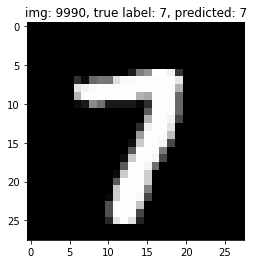

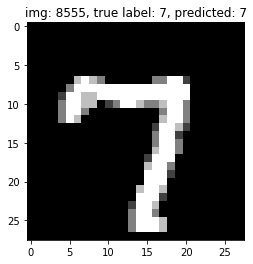

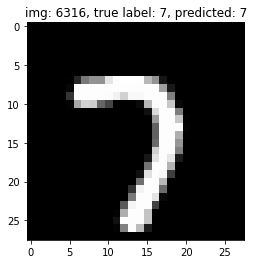

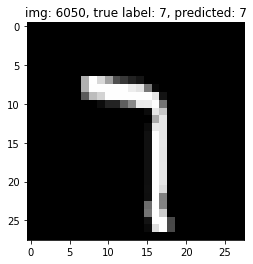

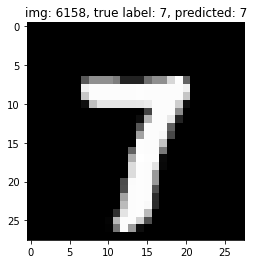

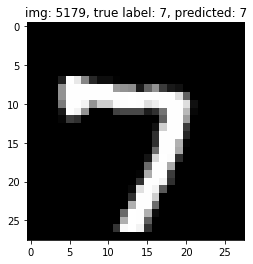

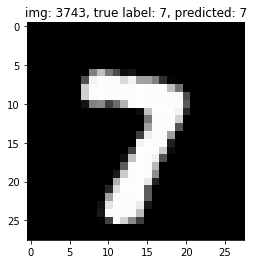

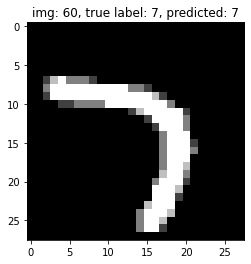

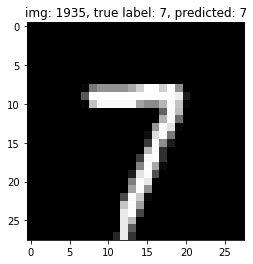

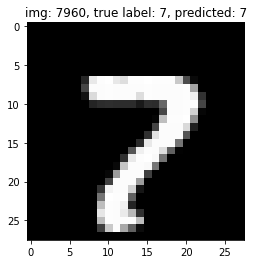

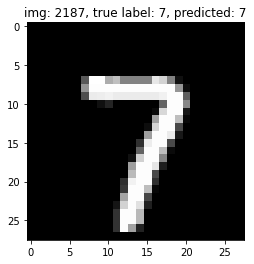

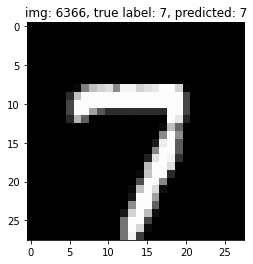

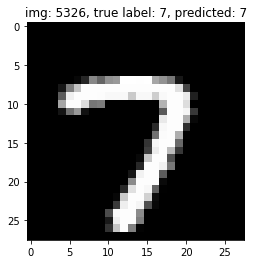

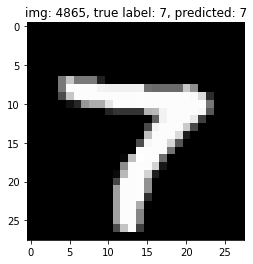

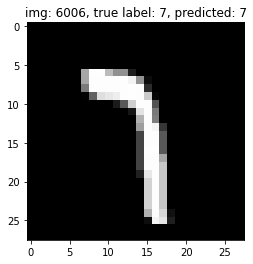

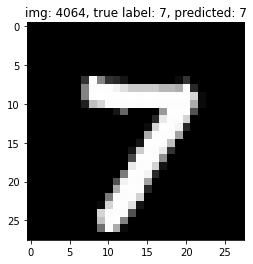

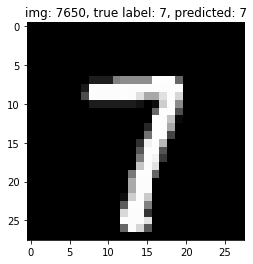

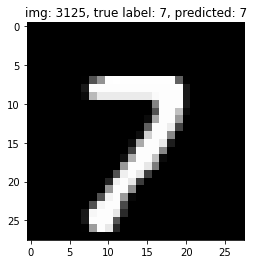

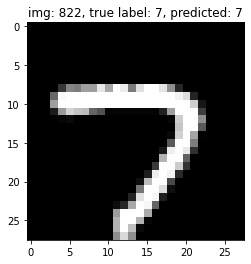

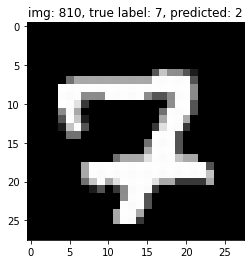

In [36]:
image_sample_id = seven_as_two
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=sorted_neurons_idx[:3])
top_k, exit_msg, is_in_partition_0, n_images_run = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

test these numbers are correct

In [37]:
# sorted_neurons_idx[:3]
res = []
image_samples = torch.stack([dataset[810]])
layer_result_image_samples = model.get_layer_result_by_layer_name(image_samples, layer_name)
brute_force = []
for i in range(layer_result_image_samples.shape[1]):
    for j in range(layer_result_image_samples.shape[2]):
        for k in range(layer_result_image_samples.shape[3]):
            brute_force.append((layer_result_image_samples[0, i, j, k], (i, j, k)))
sorted_array = sorted(brute_force, key=lambda k:k[0], reverse=True)
print(sorted_array[:20])

[(tensor(15.8217), (1, 4, 5)), (tensor(15.7167), (1, 4, 4)), (tensor(15.0591), (1, 9, 9)), (tensor(14.8148), (1, 9, 4)), (tensor(14.5511), (1, 9, 8)), (tensor(14.3026), (1, 4, 3)), (tensor(14.0647), (4, 7, 7)), (tensor(14.0015), (1, 9, 3)), (tensor(13.6643), (1, 4, 6)), (tensor(13.3799), (1, 3, 7)), (tensor(13.3682), (4, 10, 5)), (tensor(13.3470), (4, 4, 8)), (tensor(13.3225), (4, 7, 6)), (tensor(13.3120), (4, 6, 7)), (tensor(13.2246), (4, 8, 7)), (tensor(13.2128), (4, 8, 6)), (tensor(13.1988), (4, 9, 5)), (tensor(12.5805), (4, 9, 6)), (tensor(12.5095), (4, 5, 7)), (tensor(12.4553), (4, 8, 5))]


In [38]:
layer_result_image_samples = model.get_layer_result_by_layer_name(dataset, layer_name)
layer_result_image_samples

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.7560,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

image 810, size of neuron group 3
threshold: 0.14178505539894104, max in answer: 1.0623618364334106, images run: 443
threshold: 0.3224230110645294, max in answer: 1.0545425415039062, images run: 876
threshold: 0.6084662675857544, max in answer: 1.047122597694397, images run: 1304
threshold: 0.7856027483940125, max in answer: 1.047122597694397, images run: 1725
threshold: 1.121870517730713, max in answer: 1.047122597694397, images run: 2124
======================= NTA exited =======================


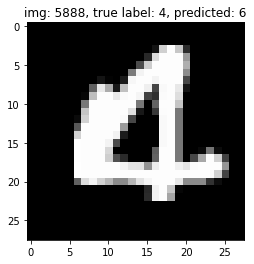

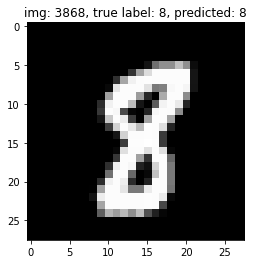

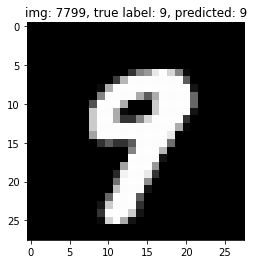

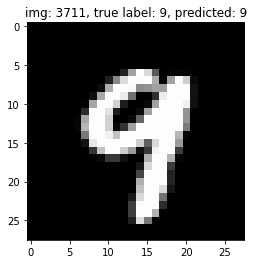

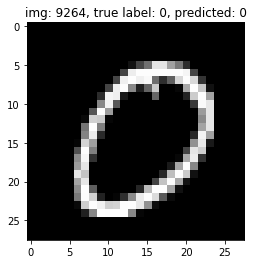

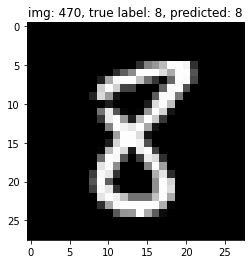

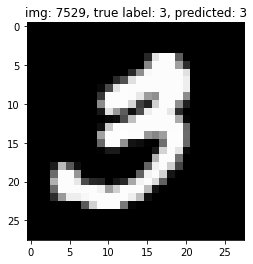

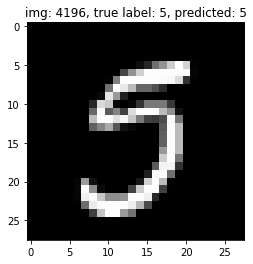

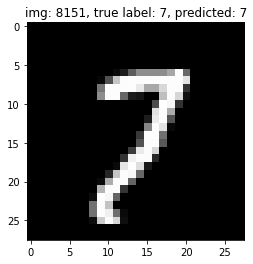

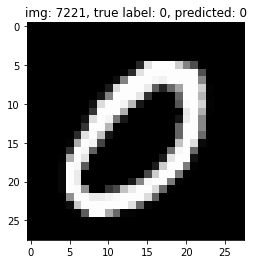

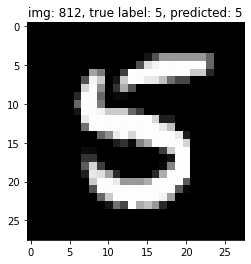

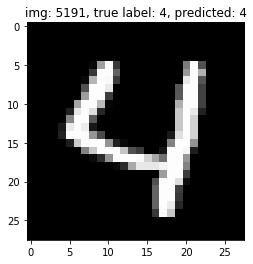

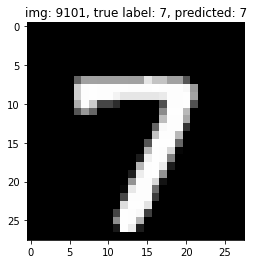

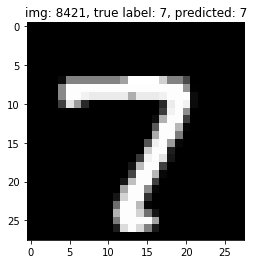

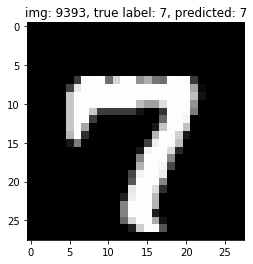

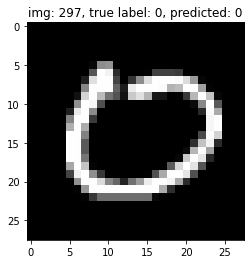

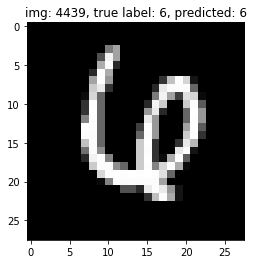

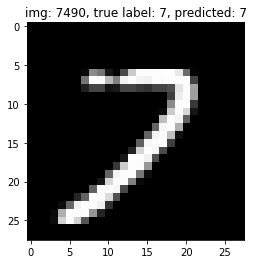

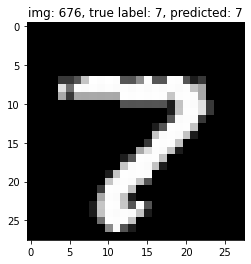

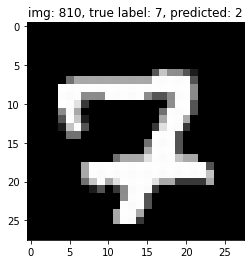

In [39]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=[(5, 0, 2), (8, 2, 2), (2, 4, 1)])
top_k, exit_msg, is_in_partition_0, n_images_run = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

In [40]:
confusion_activations = [topk_activations[2], topk_activations[3]]
neuron_cnt = dict()
for topk_activation in confusion_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1
{k: v for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)}

{(1, 3, 7): 2,
 (4, 8, 5): 2,
 (1, 4, 3): 2,
 (4, 5, 7): 2,
 (1, 4, 4): 2,
 (1, 3, 6): 1,
 (1, 3, 4): 1,
 (1, 3, 5): 1,
 (4, 3, 7): 1,
 (1, 11, 4): 1,
 (4, 6, 6): 1,
 (1, 11, 5): 1,
 (4, 5, 6): 1,
 (4, 4, 7): 1,
 (4, 7, 5): 1,
 (4, 10, 4): 1,
 (4, 9, 4): 1,
 (0, 3, 7): 1,
 (4, 8, 4): 1,
 (0, 10, 5): 1,
 (1, 4, 5): 1,
 (1, 9, 9): 1,
 (1, 9, 4): 1,
 (1, 9, 8): 1,
 (4, 7, 7): 1,
 (1, 9, 3): 1,
 (1, 4, 6): 1,
 (4, 10, 5): 1,
 (4, 4, 8): 1,
 (4, 7, 6): 1,
 (4, 6, 7): 1,
 (4, 8, 7): 1,
 (4, 8, 6): 1,
 (4, 9, 5): 1,
 (4, 9, 6): 1}